# <center><font color='red'>5 - PROCESSING OF INDIVIDUAL CELLS</font></center>

### <center><font color='orange'>AUTHOR: Diogo Vieira</font></center>

-------------------------------------------

### <center><font color='grey'>Imports</font></center>

In [15]:
# Math, image processing and other useful libraries
from __future__ import print_function, unicode_literals, absolute_import, division
import os

import pandas as pd
import numpy as np
import cv2
from collections import OrderedDict
import copy
import math
import pickle
from matplotlib.ticker import MaxNLocator
from itertools import combinations

# Image processing
from skimage.measure import regionprops
from skimage.filters import meijering, sato, frangi, hessian, threshold_otsu
from skimage.morphology import extrema, skeletonize
from skimage.transform import probabilistic_hough_line
from skimage.draw import disk, circle_perimeter
from scipy.ndimage import gaussian_filter, grey_closing
from scipy.spatial import distance_matrix
from skimage import data, restoration, util
from roipoly import RoiPoly
from matplotlib_scalebar.scalebar import ScaleBar
from biosppy.signals import tools
from biosppy.stats import pearson_correlation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as pltc
import matplotlib.colors as colors
import seaborn as sns

# Widgets
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

# Feature Extraction (.py files by Teresa Parreira)
# from CytoSkeletonPropsMorph import CytoSkeletonPropsMorph
# from CytoSkeletonRegionPropsInt import RegionPropsInt
# from FreqAnalysis import FreqAnalysis
# from GLCM import GLCM

# Graph
import sknw
import networkx as nx
from scipy.signal import argrelextrema

# 
from skan import Skeleton, summarize,draw
from skan.csr import skeleton_to_csgraph, sholl_analysis,make_degree_image
import scipy as sp
import scipy.sparse
from matplotlib.patches import Circle
from framework.ImageFeatures import ImageFeatures,getvoxelsize
from framework.Functions import cv2toski,pylsdtoski,polar_to_cartesian, remove_not1D, quantitative_analysis,hist_bin,hist_lim,create_separate_DFs,branch,graphAnalysis
from framework.Importing import label_image,init_import
from framework.PreProcessingCYTO import cytoskeleton_preprocessing, df_cytoskeleton_preprocessing
from framework.PreProcessingNUCL import excludeborder, nuclei_preprocessing, df_nuclei_preprocessing, nuclei_segmentation
from framework.Processing import process3Dnuclei,analyze_cell,df_analyze_cell
from framework.visualization import truncate_colormap, plot_hist, plot_pie, line_plotter, graph_plotter, intensity_plotter
#from fractal_dimension import fractal_dimension
#from fractal_analysis_fxns import boxcount,boxcount_grayscale,fractal_dimension,fractal_dimension_grayscale,fractal_dimension_grayscale_DBC

print('📚 All libraries successfully imported 📚')

📚 All libraries successfully imported 📚


#### <center><font color='grey'>Directories</font></center>

In [17]:
### DATASET #1 (2D)
folder    = os.path.dirname(os.getcwd()) + "\\Datasets\\Set 1-a-tubulin_Sofia"
options   = ["RGB","CYTO_DECONV","NUCL_DECONV"]

### DATASET #2 (3D)
#folder    = os.path.dirname(os.getcwd()) + "\\Datasets\\Set 3D"
#options   = ["3D"]

### DATASET #3 (Soraia)
# folder    = os.path.dirname(os.getcwd()) + "\\Datasets\\Soraia"
# options   = ["3D"]

### DATASET #4 (Inês)
# folder    = os.path.dirname(os.getcwd()) + "\\Datasets\\Ines"
#options     = []


data = init_import(folder,options,label_image)
data['NUCL_PRE'] = pd.read_pickle(folder + "\\NUCL_PRE\\NUCL_PRE.pkl") # pd.read_pickle(os.getcwd() + "\\NUCL_PRE_2D_StarDist.pkl") #
data['CYTO_PRE'] = pd.read_pickle(folder + "\\CYTO_PRE\\CYTO_PRE.pkl") 
ROIs    = pickle.load(open(folder + '\\ROIs\\'+ 'ROIs.p', 'rb'))  

>>> [RGB] added.
>>> [CYTO_DECONV] added.
>>> [NUCL_DECONV] added.


## Select features

In [6]:
import ipywidgets as widgets

# Define the groups of features
groups = {
    'DCF': [
        'DCF:Area',
        'DCF:BB Area',
        'DCF:Perimeter',
        'DCF:Area convex',
        'DCF:Centroid',
        'DCF:Weighted Centroid',
        'DCF:Centroid Divergence',
        'DCF:Equivalent Diameter',
        'DCF:Extent',
        'DCF:Major Axis Length',
        'DCF:Minor Axis Length',
        'DCF:Height',
        'DCF:Euler Number',
        'DCF:Eccentricity',
        'DCF:Circularity',
        'DCF:Roundness',
        'DCF:Orientation',
        'DCF:Solidity',
        'DCF:Roughness',
        'DCF:Hu Moment #1',
        'DCF:Hu Moment #2',
        'DCF:Hu Moment #3',
        'DCF:Weighted Hu Moment #1',
        'DCF:Weighted Hu Moment #1',
        'DCF:Weighted Hu Moment #1',
        'DCF:Feret Diameter Max',
        'DCF:Crofton Perimeter',

        'DCF:Mean Intensity',
        'DCF:Std',
        'DCF:Variance',
        'DCF:Skewness',
        'DCF:Kurtosis',
        'DCF:Contrast',
        'DCF:Max Intensity',
        'DCF:Min Intensity',
        'DCF:Entropy',
        'DCF:Inertia Tensor Highest Eigenvalue',
        'DCF:Inertia Tensor Lowest Eigenvalue',

        'DCF:Uniformity',
        'DCF:Invariant Uniformity',
        'DCF:GLCM Entropy',
        'DCF:GLCM Invariant Entropy',
        'DCF:Correlation',
        'DCF:Invariant Correlation',
        'DCF:Dissimilarity',
        'DCF:Invariant Dissimilarity',
        'DCF:Contrast',
        'DCF:Invariant Contrast',
        'DCF:Homogeneity',
        'DCF:Invariant Homogeneity',
        'DCF:Energy',
        'DCF:Invariant Energy',

        'DCF:Mean Gabor Power',
        'DCF:Gabor Variance',
        'DCF:Gabor Mean',
        'DCF:Gabor Energy',
        'DCF:Gabor Entropy',
        'DCF:Mean Spectral Magnitude',
        'DCF:Mean Spectral Power'
    ],
    'DNF': [
            'DNF:Area',
            'DNF:BB Area',
            'DNF:Perimeter',
            'DNF:Area convex',
            'DNF:Centroid',
            'DNF:Weighted Centroid',
            'DNF:Centroid Divergence',
            'DNF:Equivalent Diameter',
            'DNF:Extent',
            'DNF:Major Axis Length',
            'DNF:Minor Axis Length',
            'DNF:Height',
            'DNF:Euler Number',
            'DNF:Eccentricity',
            'DNF:Circularity',
            'DNF:Roundness',
            'DNF:Orientation',
            'DNF:Solidity',
            'DNF:Roughness',
            'DNF:Hu Moment #1',
            'DNF:Hu Moment #2',
            'DNF:Hu Moment #3',
            'DNF:Weighted Hu Moment #1',
            'DNF:Weighted Hu Moment #1',
            'DNF:Weighted Hu Moment #1',
            'DNF:Feret Diameter Max',
            'DNF:Crofton Perimeter',
            
            'DNF:Mean Intensity',
            'DNF:Std',
            'DNF:Variance',
            'DNF:Skewness',
            'DNF:Kurtosis',
            'DNF:Contrast',
            'DNF:Max Intensity',
            'DNF:Min Intensity',
            'DNF:Entropy',
            'DNF:Inertia Tensor Highest Eigenvalue',
            'DNF:Inertia Tensor Lowest Eigenvalue',
            
            'DNF:Uniformity',
            'DNF:Invariant Uniformity',
            'DNF:GLCM Entropy',
            'DNF:GLCM Invariant Entropy',
            'DNF:Correlation',
            'DNF:Invariant Correlation',
            'DNF:Dissimilarity',
            'DNF:Invariant Dissimilarity',
            'DNF:Contrast',
            'DNF:Invariant Contrast',
            'DNF:Homogeneity',
            'DNF:Invariant Homogeneity',
            'DNF:Energy',
            'DNF:Invariant Energy',
            
            'DNF:Mean Gabor Power',
            'DNF:Gabor Variance',
            'DNF:Gabor Mean',
            'DNF:Gabor Energy',
            'DNF:Gabor Entropy',
            'DNF:Mean Spectral Magnitude',
            'DNF:Mean Spectral Power'
    ],
    'LSF': [
            'LSF2D:Angles',
            'LSF2D:Distances to Centroid',
            'LSF2D:Triangle Areas',
            'LSF2D:Line Lengths',
            'LSF2D:Theta',
            'LSF2D:Angle Difference',
            'LSF2D:Std. Angle Difference',
            'LSF2D:Local Line Distance',
            'LSF2D:Std. Local Line Distance',
            'LSF2D:PAD',
           
            'LSF1D:Number of Lines',
            'LSF1D:Radial Score',
            'LSF1D:Complete Diameter Distance',
            'LSF1D:Average Diameter Distance',
            'LSF1D:TAD',
            'LSF1D:OOP',
            'LSF1D:HI',
            'LSF1D:MCM'
    ],
    'CNF': [
            'CNF1D:Number of Branches',

            'CNF2D:branch-distance',
            'CNF1D:branch-distance mean',
            'CNF1D:branch-distance median',
            'CNF1D:branch-distance min',
            'CNF1D:branch-distance max',
            'CNF1D:branch-distance max_amp',
            'CNF1D:branch-distance var',
            'CNF1D:branch-distance std_dev',
            'CNF1D:branch-distance abs_dev',
            'CNF1D:branch-distance kurtosis',
            'CNF1D:branch-distance skewness',
            
            'CNF2D:mean-pixel-value',
            'CNF1D:mean-pixel-value mean',
            'CNF1D:mean-pixel-value median',
            'CNF1D:mean-pixel-value min',
            'CNF1D:mean-pixel-value max',
            'CNF1D:mean-pixel-value max_amp',
            'CNF1D:mean-pixel-value var',
            'CNF1D:mean-pixel-value std_dev',
            'CNF1D:mean-pixel-value abs_dev',
            'CNF1D:mean-pixel-value kurtosis',
            'CNF1D:mean-pixel-value skewness',
            
            'CNF2D:stdev-pixel-value',
            'CNF1D:stdev-pixel-value mean',
            'CNF1D:stdev-pixel-value median',
            'CNF1D:stdev-pixel-value min',
            'CNF1D:stdev-pixel-value max',
            'CNF1D:stdev-pixel-value max_amp',
            'CNF1D:stdev-pixel-value var',
            'CNF1D:stdev-pixel-value std_dev',
            'CNF1D:stdev-pixel-value abs_dev',
            'CNF1D:stdev-pixel-value kurtosis',
            'CNF1D:stdev-pixel-value skewness',
            
            'CNF2D:euclidean-distance',
            'CNF1D:euclidean-distance mean',
            'CNF1D:euclidean-distance median',
            'CNF1D:euclidean-distance min',
            'CNF1D:euclidean-distance max',
            'CNF1D:euclidean-distance max_amp',
            'CNF1D:euclidean-distance var',
            'CNF1D:euclidean-distance std_dev',
            'CNF1D:euclidean-distance abs_dev',
            'CNF1D:euclidean-distance kurtosis',
            'CNF1D:euclidean-distance skewness',
            
            'CNF1D:Number of Endpoint-to-endpoint (isolated branch)',
            'CNF1D:Ratio of Endpoint-to-endpoint (isolated branch)',
            'CNF1D:Mean of Endpoint-to-endpoint (isolated branch) branch-distance',
            'CNF1D:Std of Endpoint-to-endpoint (isolated branch) branch-distance',
            'CNF1D:Mean of Endpoint-to-endpoint (isolated branch) mean-pixel-value',
            'CNF1D:Std of Endpoint-to-endpoint (isolated branch) mean-pixel-value',
            'CNF1D:Mean of Endpoint-to-endpoint (isolated branch) stdev-pixel-value',
            'CNF1D:Std of Endpoint-to-endpoint (isolated branch) stdev-pixel-value',
            'CNF1D:Mean of Endpoint-to-endpoint (isolated branch) euclidean-distance',
            'CNF1D:Std of Endpoint-to-endpoint (isolated branch) euclidean-distance',
            
            'CNF1D:Number of Junction-to-endpoints',
            'CNF1D:Ratio of Junction-to-endpoints',
            'CNF1D:Mean of Junction-to-endpoints branch-distance',
            'CNF1D:Std of Junction-to-endpoints branch-distance',
            'CNF1D:Mean of Junction-to-endpoints mean-pixel-value',
            'CNF1D:Std of Junction-to-endpoints mean-pixel-value',
            'CNF1D:Mean of Junction-to-endpoints stdev-pixel-value',
            'CNF1D:Std of Junction-to-endpoints stdev-pixel-value',
            'CNF1D:Mean of Junction-to-endpoints euclidean-distance',
            'CNF1D:Std of Junction-to-endpoints euclidean-distance',
            
            'CNF1D:Number of Junction-to-junctions',
            'CNF1D:Ratio of Junction-to-junctions',
            'CNF1D:Mean of Junction-to-junctions branch-distance',
            'CNF1D:Std of Junction-to-junctions branch-distance',
            'CNF1D:Mean of Junction-to-junctions mean-pixel-value',
            'CNF1D:Std of Junction-to-junctions mean-pixel-value',
            'CNF1D:Mean of Junction-to-junctions stdev-pixel-value',
            'CNF1D:Std of Junction-to-junctions stdev-pixel-value',
            'CNF1D:Mean of Junction-to-junctions euclidean-distance',
            'CNF1D:Std of Junction-to-junctions euclidean-distance',
            
            'CNF1D:Number of Isolated cycles',
            'CNF1D:Ratio of Isolated cycles',
            'CNF1D:Mean of Isolated cycles branch-distance',
            'CNF1D:Std of Isolated cycles branch-distance',
            'CNF1D:Mean of Isolated cycles mean-pixel-value',
            'CNF1D:Std of Isolated cycles mean-pixel-value',
            'CNF1D:Mean of Isolated cycles stdev-pixel-value',
            'CNF1D:Std of Isolated cycles stdev-pixel-value',
            'CNF1D:Mean of Isolated cycles euclidean-distance',
            'CNF1D:Std of Isolated cycles euclidean-distance',
            
            'CNF1D:Sholl Crossings Cyto mean',
            'CNF1D:Sholl Crossings Cyto median',
            'CNF1D:Sholl Crossings Cyto min',
            'CNF1D:Sholl Crossings Cyto max',
            'CNF1D:Sholl Crossings Cyto max_amp',
            'CNF1D:Sholl Crossings Cyto var',
            'CNF1D:Sholl Crossings Cyto std_dev',
            'CNF1D:Sholl Crossings Cyto abs_dev',
            'CNF1D:Sholl Crossings Cyto kurtosis',
            'CNF1D:Sholl Crossings Cyto skewness',
            
            'CNF1D:Sholl Crossings Nuclei mean',
            'CNF1D:Sholl Crossings Nuclei median',
            'CNF1D:Sholl Crossings Nuclei min',
            'CNF1D:Sholl Crossings Nuclei max',
            'CNF1D:Sholl Crossings Nuclei max_amp',
            'CNF1D:Sholl Crossings Nuclei var',
            'CNF1D:Sholl Crossings Nuclei std_dev',
            'CNF1D:Sholl Crossings Nuclei abs_dev',
            'CNF1D:Sholl Crossings Nuclei kurtosis',
            'CNF1D:Sholl Crossings Nuclei skewness'
    ]
}

# Create the checkboxes
checkboxes = {}
for group, features in groups.items():
    checkbox_group = []
    for feature in features:
        checkbox = widgets.Checkbox(value=True, description=feature)
        checkbox_group.append(checkbox)
    checkboxes[group] = checkbox_group

# Create the button
generate_button = widgets.Button(description='Generate List')
features = []

# Function to handle button click event
def generate_list(button):
    global features
    features = []
    for group in checkboxes.values():
        features.extend([checkbox.description for checkbox in group if checkbox.value])
    #print(f'Features: {features}')
    print('Variable "features" created.')

# Attach the function to the button click event
generate_button.on_click(generate_list)

# Create the checkbox groups and add vertical spacing
groups_layout = []
for group, checkboxes_group in checkboxes.items():
    checkboxes_group_layout = widgets.HBox(checkboxes_group)
    groups_layout.append(widgets.VBox([checkboxes_group_layout, widgets.HTML('<br>')]))

# Create the final layout
layout = widgets.VBox(groups_layout + [generate_button])

# Display the layout
layout


Variable "features" created.


## Select Cell

In [10]:
cell = 1

---

In [12]:
ResultsDF = analyze_cell(rowROI           = ROIs.loc[cell],
                         data             = data,
                         algorithm_cyto   = 'deconvoluted',
                         algorithm_nuclei = 0,
                         LSFparams        = [2,2.5,1],
                         features         = features)

In [13]:
ResultsDF

,Name,Img Index,Label,Mask,Patch:Skeleton,Patch:Deconvoluted Cyto,Patch:Deconvoluted Nucl,Patch:Skeleton Max,Offset,Nucleus Contour,...,CNF1D:Sholl Crossings Cyto cv,CNF1D:Sholl Crossings Nucl mean,CNF1D:Sholl Crossings Nucl median,CNF1D:Sholl Crossings Nucl min,CNF1D:Sholl Crossings Nucl max,CNF1D:Sholl Crossings Nucl var,CNF1D:Sholl Crossings Nucl std_dev,CNF1D:Sholl Crossings Nucl kurtosis,CNF1D:Sholl Crossings Nucl skewness,CNF1D:Sholl Crossings Nucl cv
0,MAX_38_IF6_CHO_L-W5_Z_decon_ch02_PS.tif,38,None,"[[False, False, False, False, False, False, Fa...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[2, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6,...","[[846, 136], [845, 137], [844, 137], [843, 137...",...,0.959336,3.119048,2.0,0,14,10.628685,3.260166,1.793149,1.435733,1.045244


# Plots

Done.


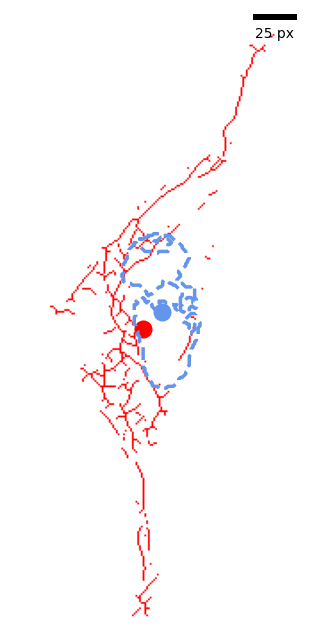

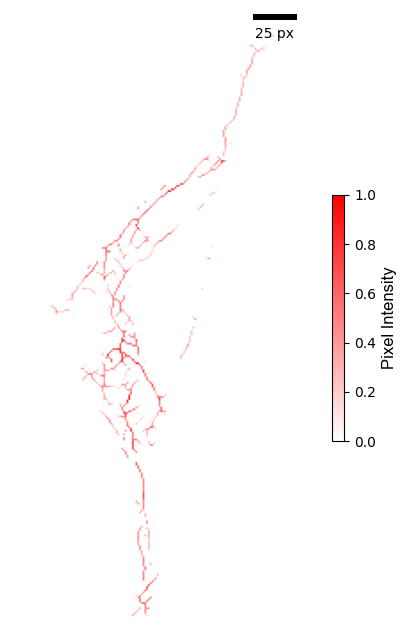

In [18]:
intensity_plotter(ResultsRow=ResultsDF.loc[cell],data=data,save=False)    

In [20]:
cmap     = pltc.rainbow
cm       = truncate_colormap(cmap, 0, 1, 300)
line_plotter(ResultsRow=ResultsDF.loc[cell],data=data,feat=None,cmap=cm,normalize_bounds=1,colorbar_label=None,overlay=True,save=False)

NameError: name 'TextureDF' is not defined

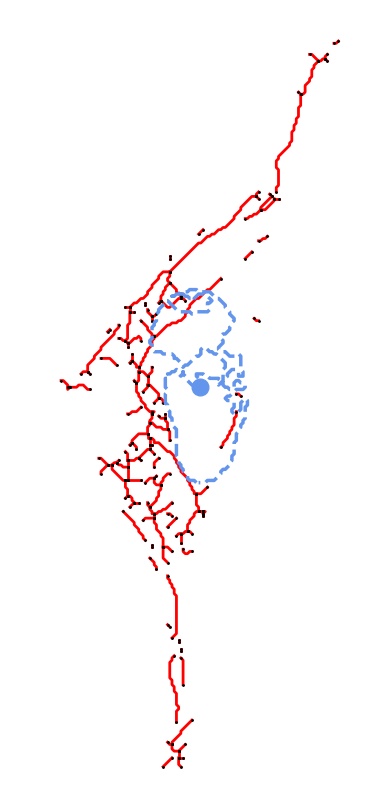

In [22]:
cmap     = pltc.rainbow
cm       = truncate_colormap(cmap, 0, 1, 300)

graph_plotter(ResultsRow       = ResultsDF.loc[cell],
              data             = data,
              feat             = None,
              cmap             = cm,
              normalize_bounds = 'default',
              colorbar_label   = None,
              nodes            = True,
              main_branch      = False,
              overlay          = None,
              scalebar         = False,
              save             = False)